In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from textblob import TextBlob
import joblib
import matplotlib.pyplot as plt

# DATA LABELLING & OUTLIERS CLEANING

In [9]:
df = pd.read_csv('output/preprocessed_data.csv')

def assign_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# # # Hitung panjang teks
# df['text_length'] = df['stemmed'].apply(len)

# # Hitung batas atas dan bawah untuk panjang teks
# Q1 = df['text_length'].quantile(0.25)
# Q3 = df['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# limit_under = Q1 - 1.5 * IQR
# limit_above = Q3 + 1.5 * IQR

# # Identifikasi outlier berdasarkan panjang teks
# outlier_idx = df[(df['text_length'] < limit_under) | (df['text_length'] > limit_above)].index

# # Hapus outlier
# df = df.drop(outlier_idx)
df['sentiment'] = df['stemmed'].apply(assign_sentiment)

# Sekarang gunakan df_cleaned untuk training model
X_cleaned = df['stemmed']
y_cleaned = df['sentiment']

# TF-IDF VECTORIZER

In [10]:
tfidf = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
nb_model = BernoulliNB()
svm_model = SVC()

nb_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', nb_model)
])

svm_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', svm_model)
])

# Setup Parameter Grid

In [11]:
nb_param_grid = {
    'tfidf__max_features': [5000, 10000],
    'classifier__alpha': [0.1, 1, 10]
}

svm_param_grid = {
    'tfidf__max_features': [5000, 10000],
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto', 0.1, 1, 10],
}

In [12]:
nb_gs = GridSearchCV(nb_pipeline, param_grid=nb_param_grid, scoring='accuracy')
svm_gs = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, scoring='accuracy')

nb_gs.fit(X_cleaned, y_cleaned)
svm_gs.fit(X_cleaned, y_cleaned)

best_nb_model = nb_gs.best_estimator_
best_svm_model = svm_gs.best_estimator_

# EVALUATE MODEL TRAINING & TESTING

Naive Bayes - Accuracy: 91.65%, Precision: 93.03%, Recall: 84.19%
SVM - Accuracy: 91.65%, Precision: 93.16%, Recall: 86.27%


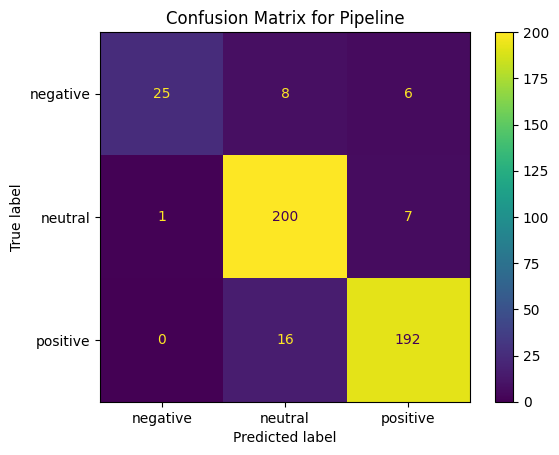

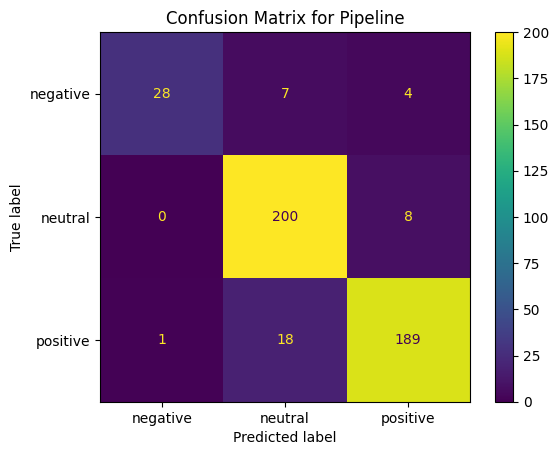

In [13]:
def evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=62)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    cm_display.ax_.set_title(f'Confusion Matrix for {type(model).__name__}')
    #plt.show()
    
    return accuracy, precision, recall

for model_name, model in [('Naive Bayes', best_nb_model), ('SVM', best_svm_model)]:
    accuracy, precision, recall = evaluate_model(model, X_cleaned, y_cleaned)
    print(f"{model_name} - Accuracy: {accuracy:.2%}, Precision: {precision:.2%}, Recall: {recall:.2%}")

# SAVE MODEL

In [14]:
joblib.dump(best_nb_model, 'output/models/sklearn/naive_bayes_model.pkl')
joblib.dump(best_svm_model, 'output/models/sklearn/svm_model.pkl')
joblib.dump(tfidf, 'output/models/sklearn/tfidf_vectorizer.pkl')

['output/models/sklearn/tfidf_vectorizer.pkl']